<a href="https://colab.research.google.com/github/teng10/ml_toric_code/blob/main/Optimization_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up

In [1]:
! git clone https://github.com/teng10/ml_toric_code.git

Cloning into 'ml_toric_code'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 565 (delta 159), reused 134 (delta 79), pack-reused 345
Receiving objects: 100% (565/565), 124.38 KiB | 13.82 MiB/s, done.
Resolving deltas: 100% (363/363), done.


In [2]:
cd /content/ml_toric_code

/content/ml_toric_code


#### install libraries

In [3]:
! pip install dm-haiku==v0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.7/309.7 KB 17.1 MB/s eta 0:00:00


In [4]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.0 MB/s eta 0:00:00


In [5]:
pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 12.7 MB/s eta 0:00:00


In [6]:
pip uninstall jax --yes

Found existing installation: jax 0.3.25
Uninstalling jax-0.3.25:
  Successfully uninstalled jax-0.3.25


In [7]:
pip uninstall jaxlib --yes

Found existing installation: jaxlib 0.3.25+cuda11.cudnn805
Uninstalling jaxlib-0.3.25+cuda11.cudnn805:
  Successfully uninstalled jaxlib-0.3.25+cuda11.cudnn805


In [8]:
pip install jaxlib==0.3.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 MB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optax 0.1.4 requires jax>=0.1.55, which is not installed.
chex 0.1.5 requires jax>=0.1.55, which is not installed.


In [9]:
pip install jax==0.3.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.15-py3-none-any.whl size=1201919 sha256=0a3b2304bb15b4b09c575f06ac09f17ee7bac4a353f87b246fa22beb834cf9bd
  Stored in directory: /root/.cache/pip/wheels/31/51/71/ce82b0bcd2fda6939ab07e219578ce881699eb1344055255af
Successfully built jax


#### Import modules

In [26]:
from ml_toric_code import bonds
from ml_toric_code import sample_utils
from ml_toric_code import utils
from ml_toric_code import operators
from ml_toric_code import tc_utils
from ml_toric_code import wavefunctions
from ml_toric_code import train_utils
from ml_toric_code import mcmc
from ml_toric_code import optimizations
# from ml_toric_code import plot_utils
from ml_toric_code import overlaps
from ml_toric_code import diffusion_map
from ml_toric_code import estimates_mcmc
from ml_toric_code import mcmc_param
from ml_toric_code import notebook_fn

In [36]:
import math
import numpy as np
import haiku as hk
import optax
import jax
import jax.numpy as jnp
import functools
import pickle
import importlib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn
from google.colab import files

## Some specific functions

In [34]:
round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

### plotting

In [32]:
def plot_accepts(ax, num_accepts, h_field):  
  num_step, len_chain = num_accepts.shape
  x_steps = np.arange(len_chain)
  for i in range(num_step - 5, num_step):
    ax.scatter(x_steps, num_accepts[i, :], label=f'{i}th step')
  # ax.legend()
  ax.set_title(f"h_z = {h_field}")
  ax.set_xlabel("Pos in Chain")
  ax.set_ylabel("Number of accepts")

def plot_energies(energy_expectation, label=None):  
  num_step = energy_expectation.shape[0]
  x_steps = np.arange(num_step)
  plt.plot(x_steps, energy_expectation[:], label=label)
  plt.legend()
  plt.xlabel("Steps")
  plt.ylabel("Energy <E>")

def plot_energies_field(num_spins, h_field_array, energy):  
  # h_field_array = np.arange(h_field[0], h_field[1], h_field[2])
  plt.scatter(h_field_array, energy, label=f"N = {num_spins}")
  plt.plot(h_field_array, -h_field_array- 0.5, label='magnetic field')
  horiz_line_data = np.array([-1 for i in range(len(h_field_array))])
  plt.plot(h_field_array, horiz_line_data, '--', label='zero field energy')
  plt.legend()
  plt.xlabel("h_z")
  plt.ylabel("Energy <E> / N_spin")

def plot_weights(axarray, params, h_field, model_name):
	"""
	Plot weights for rbm ansatz
	"""
	bias_F =  params[model_name]['bF']
	bias_V =  params[model_name]['bV']
	weights_F = params[model_name]['wF'] / (np.pi / 4.)
	# print(weights_F.shape)
	weights_F = np.expand_dims(weights_F, 1)
	# weights_F = np.squeeze(np.squeeze(weights_F, -1), -1)
	weights_V = params[model_name]['wV'] / (np.pi / 4.)
	weights_V = np.expand_dims(weights_V, 1)
	# weights_V = np.squeeze(np.squeeze(weights_V, -1), -1)
	seaborn.heatmap(weights_F, ax=axarray[0], annot=True)
	axarray[0].set_title(f"Plaquette (pi/4), b={round_to_n(bias_F, 2)}", pad=10)
	seaborn.heatmap(weights_V, ax=axarray[1], annot=True)
	axarray[1].set_title(f"Vertex, b={round_to_n(bias_V, 2)}", pad=10) 

## Optimization

In [13]:
def main(h_field_range, epsilon, spin_shape, num_chains, num_steps, first_burn_len, len_chain, learning_rate, spin_flip_p, sector):
  rng_seq = hk.PRNGSequence(42)  # generates a stream of rng_keys; `next(rng_seq)` 
  num_spins = spin_shape[0] * spin_shape[1]
  init_configs = sample_utils.init_samples(next(rng_seq), num_spins, num_chains)     #Create intial chains

  model = hk.without_apply_rng(hk.transform(wavefunctions.fwd))
  psi_apply = functools.partial(model.apply, spin_shape=spin_shape)
  psi_apply_vectorized = jax.vmap(psi_apply, in_axes=(None, 0))     #vmap psi  

  # Set intial random parameters
  noise_key = next(rng_seq)     #key for adding noise
  model_params = tc_utils.get_rbm_params(sector)      # Get initial parameter for sector
  params = tc_utils.generate_uniform_noise_param(noise_key, model_params, epsilon)

  # Full optimization for each field value
  def _update_fields(carry, inputs):
    # Initialize params and configs, psis from previous field
    carried_params, carried_configs, carried_psis = carry
    h_field, key = inputs
    #Optimizer initialization
    opt_init, opt_update = optax.adam(learning_rate)
    opt_state = opt_init(carried_params)
    # Define hamiltonian 
    myham = tc_utils.set_up_ham_field(spin_shape, h_field)
    # Define propose move fn
    vertex_bonds = tc_utils.get_vertex_bonds(spin_shape)
    propose_move_fn = functools.partial(mcmc.propose_move_fn, p=spin_flip_p, vertex_bonds=vertex_bonds)
    # First burn update chain function
    update_chain_fn_first_burn = functools.partial(mcmc.update_chain,        #vmap update_chain for first burn
                                        len_chain=first_burn_len, psi=psi_apply, 
                                        propose_move_fn=propose_move_fn, make_move_fn=sample_utils.vertex_bond_sample, 
                                        )
    update_chain_first_burn_vec = jax.vmap(update_chain_fn_first_burn, in_axes=(0, 0, 0, None))
    # Equilibrated configs and psis
    new_key, sub_key = jax.random.split(key)
    rngs = utils.split_key(new_key, np.array([num_chains, 2]))
    equilibrated_configs, equilibrated_psis, __ = update_chain_first_burn_vec(rngs, carried_configs, carried_psis, carried_params)

    # Define partial MCMC_optimization fn
    MCMC_optimization_fn = functools.partial(optimizations.MCMC_optimization, psi=psi_apply, init_params=carried_params, opt_update=opt_update, init_opt_state=opt_state, num_steps=num_steps, 
                                             len_chain=len_chain, propose_move_fn=propose_move_fn, make_move_fn=sample_utils.vertex_bond_sample, ham=myham,
                                                                                                              learning_rate=learning_rate)
    #compile with jit
    MCMC_optimization_jit = jax.jit(MCMC_optimization_fn)

    ((new_batch_configs, new_batch_psis, new_model_params, new_opt_state), 
      (num_accepts, energy_expectation, grad_psi_expectation, grad_energy_expectation)) = MCMC_optimization_jit(sub_key, equilibrated_configs, equilibrated_psis )
    return (new_model_params, new_batch_configs, new_batch_psis), energy_expectation[:, 0], num_accepts, grad_energy_expectation

  # Define the field values range in x-direction
  h_field_array = np.arange(h_field_range[0], h_field_range[1], h_field_range[2])
  # h_field = h_field_array
  h_field_length = h_field_array.shape[0] 
  # Create key for all field values
  rngs = jax.random.split(next(rng_seq), h_field_length)      #Split the keys based on batch size and steps

  # List for saving parameters and energies
  new_params_list = []
  energy_density_list = []
  energy_steps_list = []
  psis_list = []
  num_accepts_list = []
  grad_list = []

  new_params = params
  new_configs = init_configs
  new_psis = psi_apply_vectorized(new_params, init_configs)
  for i in range(h_field_length):
    print(f"{i}/{h_field_length}-th iteration")
    (updated_params, updated_configs, updated_psis), energy_steps, num_accepts, grad_energy_expectation = _update_fields((new_params, new_configs, new_psis), 
                                                                                                          (h_field_array[i], rngs[i, :]))
    new_params = updated_params
    new_configs = updated_configs
    new_psis = updated_psis
    new_params_list.append(new_params)
    energy_density_list.append(energy_steps[-1] / num_spins)
    energy_steps_list.append(energy_steps / num_spins)
    psis_list.append(updated_psis)
    num_accepts_list.append(num_accepts)
    grad_list.append(grad_energy_expectation)

    print(f"Current energy is {energy_steps[-1] / num_spins}")
  return new_params_list, energy_density_list, updated_psis, energy_steps_list, psis_list,num_accepts_list, grad_list

In [14]:
#@title Optimization with finite fields $h$
h_field_range=[0.0, 2.5, 0.1]
h_field_array = np.arange(h_field_range[0], h_field_range[1], h_field_range[2])
spin_shape = (6,3)
num_spins = spin_shape[0] * spin_shape[1]
sector = 1
params_list, energy, psis, energy_steps, psis_list, num_accepts_list, grad_list = main(h_field_range=h_field_range, epsilon=.1, spin_shape=spin_shape, num_chains=300, num_steps=100, 
                                                          first_burn_len=180, len_chain=30, learning_rate=0.005, spin_flip_p=.4, sector=sector)

/content/ml_toric_code/tc_utils.py:117: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  param_arrays, tree_def = jax.tree_flatten(param_dict)
/content/ml_toric_code/tc_utils.py:122: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  noise_values = jax.tree_unflatten(tree_def, noise_values)
/content/ml_toric_code/tc_utils.py:125: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x, y: x + y, param_dict, noise_values)
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:143: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:14

0/25-th iteration


/content/ml_toric_code/operators.py:161: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  return jax.tree_leaves(cs), jax.tree_leaves(matrix_elements)
/content/ml_toric_code/train_utils.py:20: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x: x / psi_config, psi_grad)       #grad_psi = grad psi(c) / psi(c)
/content/ml_toric_code/train_utils.py:28: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda x: energy_local * x, psi_grad)
/content/ml_toric_code/train_utils.py:59: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  energy_grad_psi_mean = jax.tree_map(lambda x: jnp.mean(x, axis=0), energy_grad_psi_batch)
/content/ml_toric_code/train_utils.

Current energy is -1.0000237226486206
1/25-th iteration
Current energy is -1.0024007558822632
2/25-th iteration
Current energy is -1.0097272396087646
3/25-th iteration
Current energy is -1.0219569206237793
4/25-th iteration
Current energy is -1.041508436203003
5/25-th iteration
Current energy is -1.075085163116455
6/25-th iteration
Current energy is -1.10526442527771
7/25-th iteration
Current energy is -1.127932071685791
8/25-th iteration
Current energy is -1.318168044090271
9/25-th iteration
Current energy is -1.4058964252471924
10/25-th iteration
Current energy is -1.5031262636184692
11/25-th iteration
Current energy is -1.599521517753601
12/25-th iteration
Current energy is -1.710557460784912
13/25-th iteration
Current energy is -1.8080649375915527
14/25-th iteration
Current energy is -1.8894693851470947
15/25-th iteration
Current energy is -1.997620701789856
16/25-th iteration
Current energy is -2.0882418155670166
17/25-th iteration
Current energy is -2.2061896324157715
18/25-th it

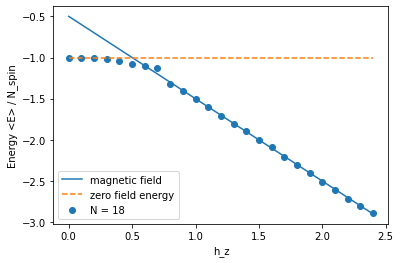

In [22]:
#@title energy expectations after optimization
plot_energies_field(num_spins, h_field_array, energy)

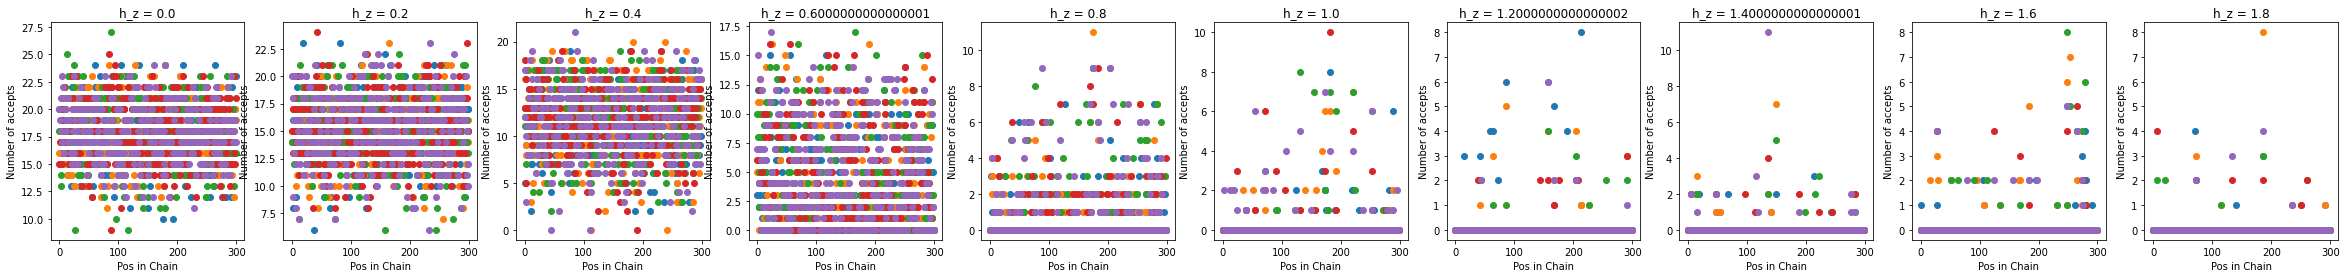

In [28]:
fig, axs = plt.subplots(1, 10, figsize=(41, 4))
counter=0
for idx, num_accepts in enumerate(num_accepts_list):
  if idx % 2 == 0:
    if counter <10:
      plot_accepts(axs[counter], num_accepts, h_field_array[idx])
      counter+=1

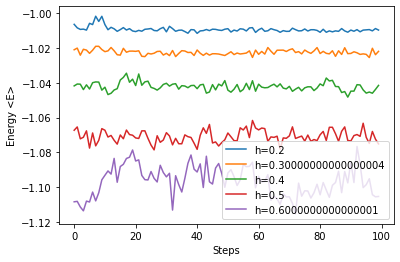

In [30]:
for idx, energy_step in enumerate(energy_steps):
  h = h_field_array[idx]
  if 0.1 < h <0.7:
    plot_energies(energy_step, label=f"h={h_field_array[idx]}")

<ipython-input-37-101597761def>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))


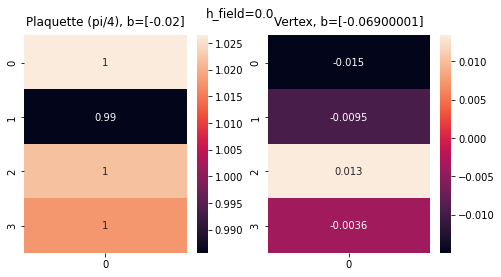

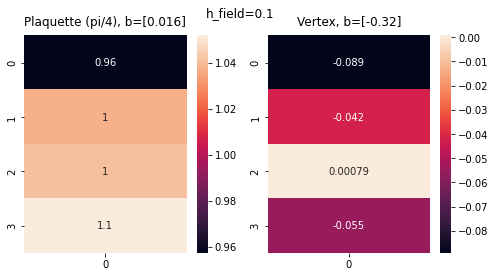

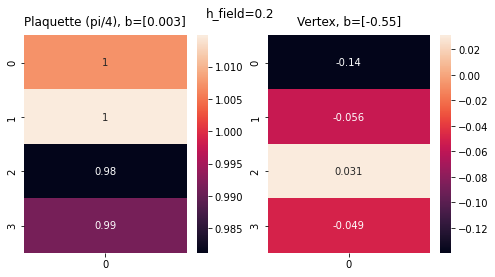

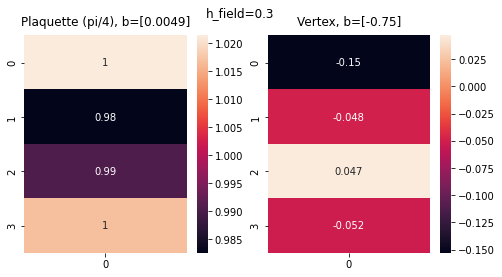

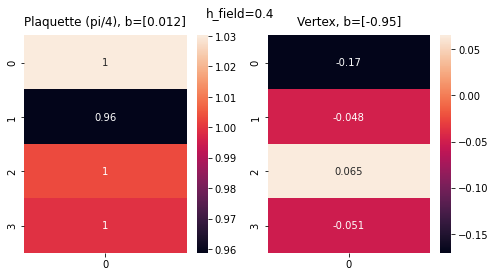

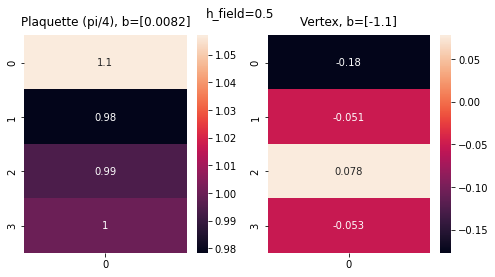

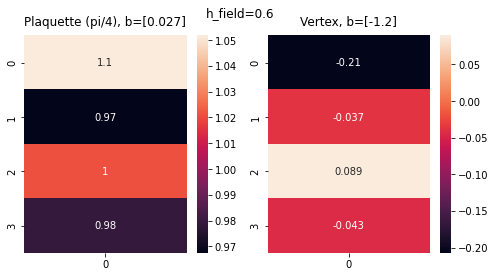

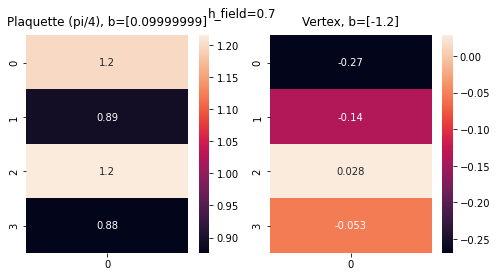

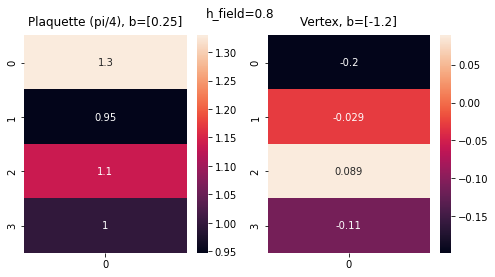

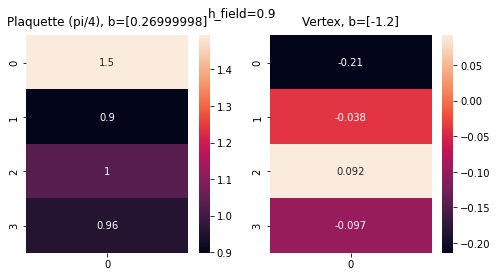

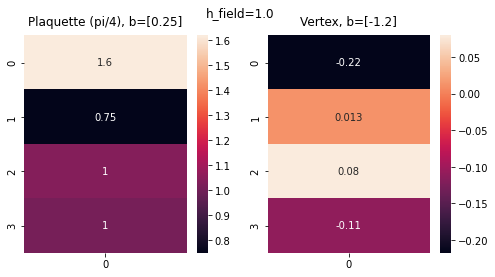

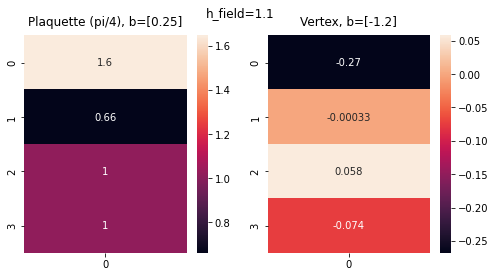

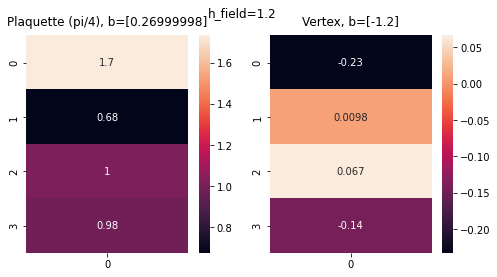

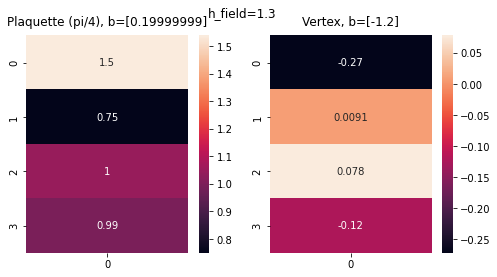

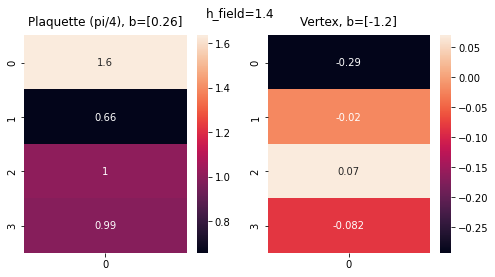

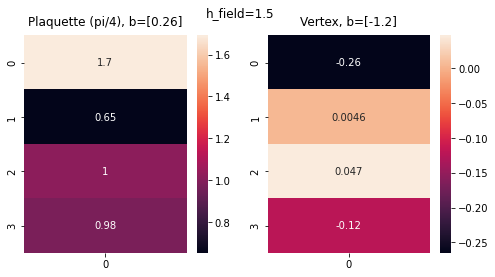

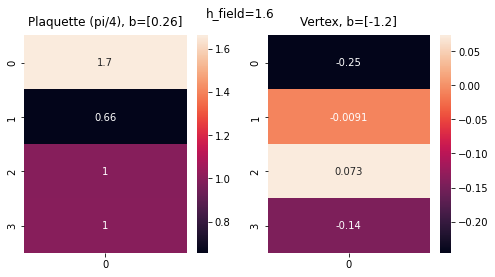

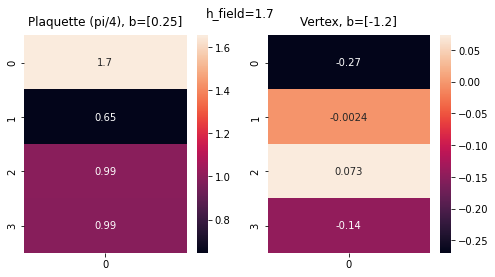

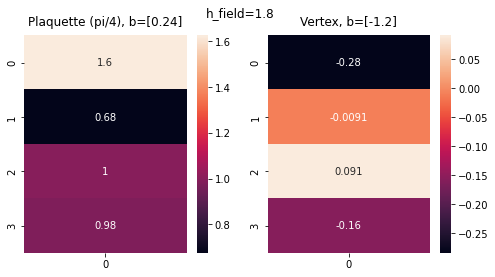

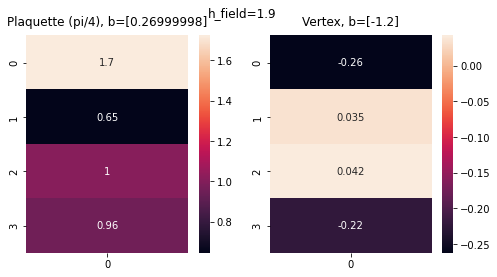

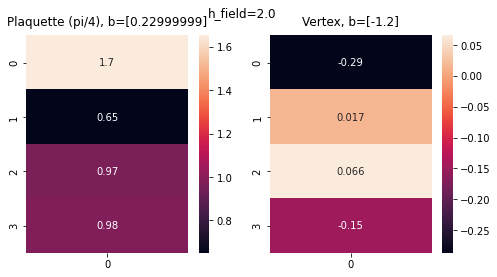

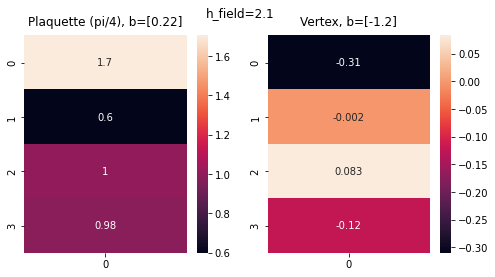

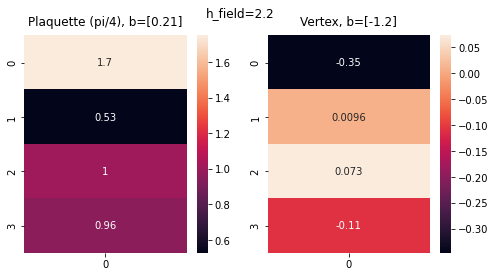

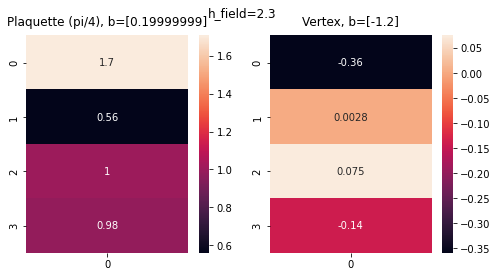

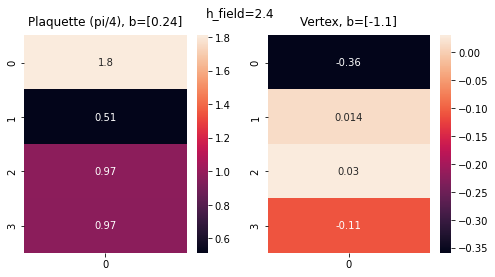

In [37]:
#@title To visualize optimized weights
for idx, params in enumerate(params_list):
  h = h_field_array[idx]
  if 1==1:
    param_keys = params.keys()
    model_names = [s.split('/')[0] for s in param_keys]
    model_names = np.unique(model_names)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f'h_field={utils.round_to_n(h_field_array[idx], 3)}')
    plot_weights(axs, params, h_field_array[idx], model_names[0])


In [39]:
#@title Download parameters
h_field_list = [utils.round_to_2(h) for h in h_field_array]
field_params_dict = dict(zip(h_field_list, params_list))
file_name = f"params_list_{spin_shape}_{sector}.p"
pickle.dump(field_params_dict, open(file_name, 'wb'))
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>